In [1]:
import os
import sys
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import signal, fftpack

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

In [4]:
%matplotlib notebook

#### Load CCF

In [5]:
mcc = MouseConnectivityCache(resolution=10)
str_tree = mcc.get_structure_tree()

### Define data path

In [6]:
rec_folder = r'F:\EEG_exp\mouse569062\estim_vis_2021-02-18_11-17-51\experiment1\recording1'
exp = EEGexp(rec_folder, preprocess=False, make_stim_csv=False)

## Location to save plots ##
# plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'mouse' + exp.mouse)
# if not os.path.exists(plotsavedir):
#     os.mkdir(plotsavedir)

## To tag plots with the experiment name ##
exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

Experiment type: electrical and sensory stimulation
estim_vis


#### Load stim table

In [7]:
stim_log = pd.read_csv(exp.stimulus_log_file)
stim_log = stim_log.astype({'parameter': str})
stim_log.head()

,stim_type,parameter,onset,offset,duration,sweep,good,mean_speed,resting_trial
0,biphasic,35,310.40707,310.40747,0.0004,0,True,0.0,True
1,biphasic,15,313.94009,313.94049,0.0004,0,True,0.0,True
2,biphasic,35,318.00171,318.00211,0.0004,0,True,0.0,True
3,biphasic,60,322.38399,322.38439,0.0004,0,True,0.0,True
4,biphasic,60,326.55359,326.55399,0.0004,0,True,0.0,True


In [8]:
stim_log.tail()

,stim_type,parameter,onset,offset,duration,sweep,good,mean_speed,resting_trial
1435,circle,white,7698.41097,7698.66039,0.24942,2,True,0.0,True
1436,circle,white,7702.86468,7703.11413,0.24945,2,True,0.0,True
1437,circle,white,7707.03484,7707.28430,0.24946,2,True,0.0,True
1438,circle,white,7711.48856,7711.73804,0.24948,2,True,0.0,True
1439,circle,white,7716.20919,7716.45863,0.24944,2,True,0.0,True


List the types of data in this experiment:
'recordingX' denotes that there is EEG data, 'probeX_sorted' denoted Neuropixels data

In [9]:
exp.experiment_data

['probeB_sorted', 'probeD_sorted', 'probeF_sorted', 'recording1']

### Get a list of NPX probes in this experiment

In [10]:
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
print(probe_list)

['probeB', 'probeD', 'probeF']


The probe names come from where on the rig the probe is mounted, not specific to a brain area. In the more recent experiments the following are likely locations:<br>
- probeF: motor cortex, anterior cingulate
- probeB: somatosensory cortex, thalamus (motor-related)
- probeC (or D): visual cortex, thalamus (visual or motor related)

Having a list of the probe names ('probeB') is helpful for accessing parameters that are stored in the EEGexp class, like below:

In [11]:
exp.ephys_params['probeF'].keys()

dict_keys(['probe_info', 'num_chs', 'bit_volts', 'ap_continuous', 'ap_timestamps', 'ap_sample_rate', 'lfp_continuous', 'lfp_timestamps', 'lfp_sample_rate', 'spike_clusters', 'spike_times', 'cluster_group', 'cluster_metrics', 'waveforms'])

### Now loop through all probes in this experiment and gather info that is useful for analysis

In [11]:
probe_info = {}
for probei in probe_list:
    probe_info[probei] = {}
    
    ### Every probe has a .json file that contains channel location information, etc.
    with open(exp.ephys_params[probei]['probe_info']) as data_file:
        data = json.load(data_file)
    npx_allch = np.array(data['channel']) # this is an array from 0 to 384
    surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
    allch_z = np.array(data['vertical_pos']) # vertical position of each electrode (um), relative to the tip (ch 0 is 20 um from tip)
    ref_mask = np.array(data['mask']) # contains a False for Npx reference channels and "bad chs"
    print('{} surface channel: {:d}'.format(probei, surface_ch))
    probe_info[probei]['surface_channel'] = surface_ch

    ## Get an array of "good" chs that are in the brain ##
    probe_info[probei]['brain_chs'] = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch])
    
    ## Get the depth of all chs relative to brain surface (in um, positive is deep in brain) ##
    probe_info[probei]['ch_depths'] = allch_z[surface_ch] - allch_z
    
    ## Get saline chs for re-ref ##
    ## Chooses 10 chs in the ACSF, but a few chs above the brain surface ##
    if surface_ch + 25 > 384:
        probe_info[probei]['saline_chs'] = np.arange(383, 373, -1)
    else:
        probe_info[probei]['saline_chs'] = np.arange(surface_ch + 15, surface_ch + 25)
    
    ## If we have completed the preprocessing step to assign CCF locations to the probe ##
    if 'area_ch' in data.keys():
        probe_info[probei]['ch_areas'] = np.array(data['area_ch'])
        probe_info[probei]['ch_CCF_coords'] = np.array(data['ccf_coord_ch']) # a list [AP, DV, ML] of CCF coordinates
        
        ## My attempt to distinguish chs that are in the cortex ##
        ## Uses the CCF to find if the area has 315 in its structure tree, 315 is the CCF id of the "Isocortex"
        ctx_mask = []
        for chi in probe_info[probei]['brain_chs']:
            if probe_info[probei]['ch_areas'][chi] != 'null':
                ctx_mask.append(
                    315 in str_tree.get_structures_by_acronym([probe_info[probei]['ch_areas'][chi]])[0]['structure_id_path'])
            else:
                ctx_mask.append(False)
        probe_info[probei]['ctx_mask'] = np.array(ctx_mask)
    else:
        print('{} does not have area assignments.'.format(probei))

probeB surface channel: 330
probeD surface channel: 345
probeF surface channel: 265


### Access full LFP traces

In [12]:
## Choose a probe to look at ##
pprobe = 'probeF'

## Memory-map the raw LFP data ##
rawmm = np.memmap(exp.ephys_params[pprobe]['lfp_continuous'], dtype='int16', mode='r')

## It loads as a long, multiplexed array, so re-shape it into array [samples, chs] ##
lfp_data_mm = np.reshape(rawmm, (int(rawmm.size/exp.ephys_params[pprobe]['num_chs']), exp.ephys_params[pprobe]['num_chs']))
# Note this data is still in bits, not in microvolts #

## Load the aligned timestamps (s) ##
lfp_ts = np.load(exp.ephys_params[pprobe]['lfp_timestamps'])

In [14]:
lfp_ts[-20:]

array([8653.41164764, 8653.41204764, 8653.41244764, 8653.41284764,
       8653.41324763, 8653.41364763, 8653.41404763, 8653.41444763,
       8653.41484763, 8653.41524763, 8653.41564763, 8653.41604763,
       8653.41644763, 8653.41684763, 8653.41724763, 8653.41764763,
       8653.41804763, 8653.41844763, 8653.41884763, 8653.41924762])

Let's look at the first 60 s

In [18]:
sampind = 410 * exp.ephys_params[pprobe]['lfp_sample_rate']

## Load 60 s from all channels and convert to uV
lfp_traces = lfp_data_mm[:sampind, :] * exp.ephys_params[pprobe]['bit_volts']

## Get saline re-ref trace ##
ref_trace = np.mean(lfp_traces[:, probe_info[pprobe]['saline_chs']], axis=1)

## Now get re-ref traces for chs in brain only ##
lfp_traces = lfp_traces[:, probe_info[pprobe]['brain_chs']] - ref_trace[:, None]

## Apply a bandpass filter ##
# filtb, filta = signal.butter(3, np.array([0.1, 100])/(exp.ephys_params[pprobe]['lfp_sample_rate']/2), btype='bandpass')
# lfp_traces = signal.filtfilt(filtb, filta, lfp_traces, axis=0)

<IPython.core.display.Javascript object>


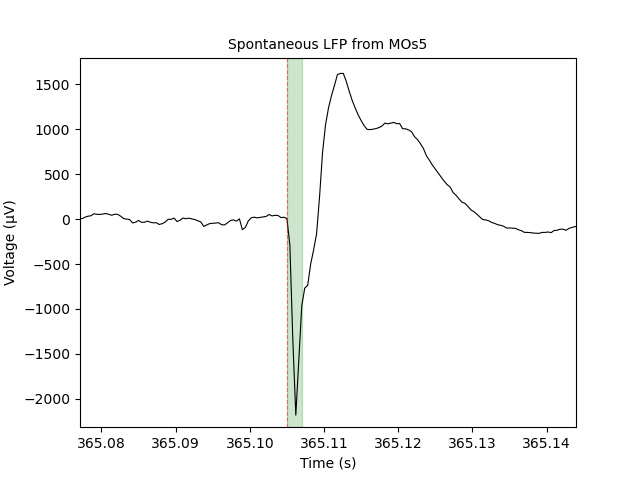

Text(0.5, 1.0, 'Spontaneous LFP from MOs5')

In [24]:
choose_region = 'MOs5'
region_mask = probe_info[pprobe]['ch_areas'][probe_info[pprobe]['brain_chs']] == choose_region

fig, ax = plt.subplots()
ax.plot(lfp_ts[:sampind], lfp_traces[:, region_mask][:,5], color='k', linewidth=0.8)#, alpha=0.2)

for eventi in stim_log['onset'].values[stim_log['onset'].values < 410]:
    ax.axvline(eventi, color='r', linestyle='dashed', linewidth=0.8, alpha=0.5)
    ax.axvspan(eventi, eventi+0.002, color='g', alpha=0.2)

# ax.set_xlim([lfp_ts[:sampind][0], lfp_ts[:sampind][-1]])
ax.set_xlim([315., lfp_ts[:sampind][-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (\u03bcV)')
# ax.set_ylabel('not converted (bits)')
ax.set_title('Spontaneous LFP from {}'.format(choose_region))

<IPython.core.display.Javascript object>


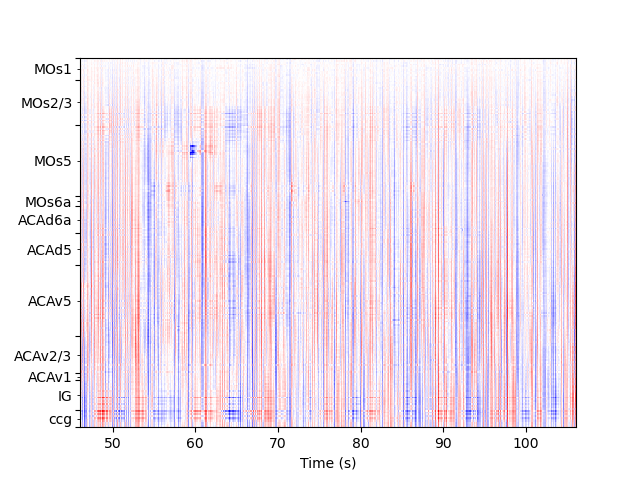

In [43]:
fig, ax = plt.subplots()
ax.imshow(
    lfp_traces.T, origin='lower', aspect='auto', cmap='bwr', vmin=-400, vmax=400, interpolation='none',
    extent=[lfp_ts[:sampind][0], lfp_ts[:sampind][-1], 0, lfp_traces.shape[1]]
)
ax.set_xlabel('Time (s)')

## Set labels ##
brain_ch_areas = probe_info[pprobe]['ch_areas'][probe_info[pprobe]['brain_chs']]
bord = [0]
regi = brain_ch_areas[0]
labels = [regi]
for indb, regb in enumerate(brain_ch_areas[1:]):
    if regb == regi:
        continue
    else:
        bord.append(indb+1)
        labels.append(regb)
        regi = regb
bord.append(len(brain_ch_areas))
label_locs = bord[:-1] + np.diff(bord)/2
        
ax.set_yticks(bord)
ax.set_yticklabels('')

ax.set_yticks(label_locs, minor=True)
ax.set_yticklabels(labels, minor=True);

### LFP event-related traces...takes awhile to process all stimuli

In [13]:
before_event = 0.5 # time before event, s
after_event = 0.5 # time after event, s
saline_re_ref = True # Re-reference the signals to the chs in saline/ACSF above brain?

probe_LFP_traces = {}
for probei in probe_list:
    print(probei)
    probe_LFP_traces[probei] = {}
    start = time.time()
    
    ## Memory-map the raw LFP data ##
    rawmm = np.memmap(exp.ephys_params[probei]['lfp_continuous'], dtype='int16', mode='r')
    ## It loads as a long, multiplexed array, so re-shape it into array [samples, chs] ##
    lfp_data_mm = np.reshape(
        rawmm, (int(rawmm.size/exp.ephys_params[probei]['num_chs']), exp.ephys_params[probei]['num_chs']))
    ## Load the aligned timestamps (s) ##
    lfp_ts = np.load(exp.ephys_params[probei]['lfp_timestamps'])
    
    ## This loops through all stimuli and sweeps and gathers event-related traces ##
    for st_type in stim_log.stim_type.unique():
        probe_LFP_traces[probei][st_type] = {}
        param_list = np.sort(stim_log[stim_log['stim_type']==st_type].parameter.unique())
        for parami in param_list:
            probe_LFP_traces[probei][st_type][parami] = {}
            sweep_list = np.sort(
                stim_log[(stim_log['stim_type']==st_type) & (stim_log['parameter']==parami)].sweep.unique())
            for sweepi in sweep_list:
                events = get_stim_events(stim_log, st_type, parami, sweepi)
                
                ## Get evoked LFP traces ##
                lfp_event_traces, lfp_event_ts = get_evoked_traces(
                    lfp_data_mm,
                    lfp_ts,
                    events,
                    before_event,
                    after_event,
                    exp.ephys_params[probei]['lfp_sample_rate']
                )
                if saline_re_ref:
                    ref_trace = np.mean(lfp_event_traces[:, probe_info[probei]['saline_chs'], :], axis=1)
                    lfp_event_traces = ((lfp_event_traces[:,probe_info[probei]['brain_chs'],:] - ref_trace[:, None, :]) *
                                        exp.ephys_params[probei]['bit_volts'])
                    lfp_event_traces = lfp_event_traces - np.mean(lfp_event_traces[lfp_event_ts < 0.005, :, :], axis=0)
                else:
                    lfp_event_traces = (lfp_event_traces[:,probe_info[probei]['brain_chs'],:] *
                                  exp.ephys_params[probei]['bit_volts'])
                    lfp_event_traces = lfp_event_traces - np.mean(lfp_event_traces[lfp_event_ts < 0.005, :, :], axis=0)

                filtb, filta = signal.butter(
                    3, np.array([0.1, 100])/(exp.ephys_params[probei]['lfp_sample_rate']/2), btype='bandpass')
                probe_LFP_traces[probei][st_type][parami][sweepi] = [
                    lfp_event_ts, signal.filtfilt(filtb, filta, lfp_event_traces, axis=0)
                ]
    end = time.time()
    print('Time: {:.3f} min'.format((end-start)/60))
    del rawmm
    del lfp_data_mm
    del lfp_ts

probeB
Time: 2.378 min
probeD
Time: 2.470 min
probeF
Time: 2.071 min


<IPython.core.display.Javascript object>


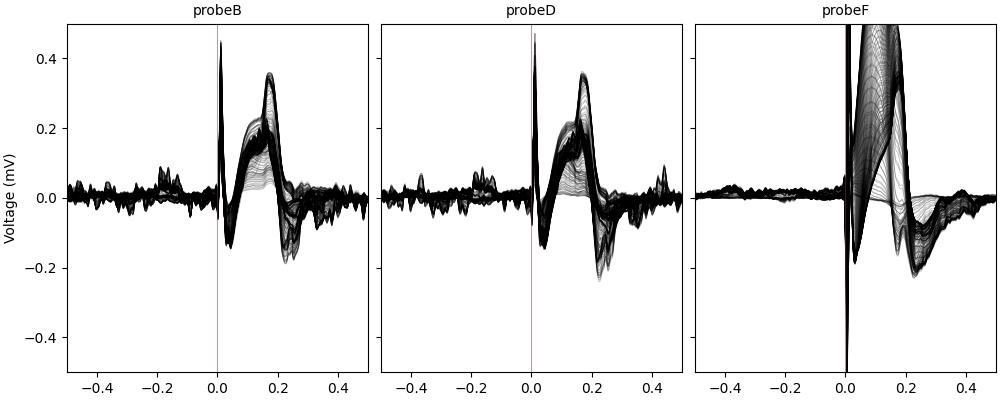

In [16]:
stim_type = 'biphasic' # 'fullscreen', 'auditory', 'biphasic'
stim_amp = '35' # current amplitude = [20, 50, 70, 100]
sweep = 0
pl_ctx = False

y_max = 0.5

fig, axs = plt.subplots(1, len(probe_list), figsize=(10,4), sharex=True, sharey=True, constrained_layout=True)
for ax, probei in zip(axs, probe_list):
    timex = probe_LFP_traces[probei][stim_type][stim_amp][sweep][0]
    traces = np.mean(probe_LFP_traces[probei][stim_type][stim_amp][sweep][1], axis=2)/1000
    if pl_ctx:
        ax.plot(timex, traces[:,probe_info[probei]['ctx_mask']], color='k', linewidth=0.6, alpha=0.25)
    else:
        ax.plot(timex, traces, color='k', linewidth=0.6, alpha=0.25)
    ax.axvline(0, color='r', linewidth=0.8, alpha=0.5)
    ax.set_title(probei)
    
axs[0].set_xlim([timex[0], timex[-1]])
axs[0].set_ylim([-y_max, y_max])
axs[0].set_ylabel('Voltage (mV)')

### SAVE ###
fig_name = '{}_NPX-LFP_allprobes_{}_sweep{}_1200.png'.format(exp_tag, str(stim_amp), sweep)
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=True)

<IPython.core.display.Javascript object>


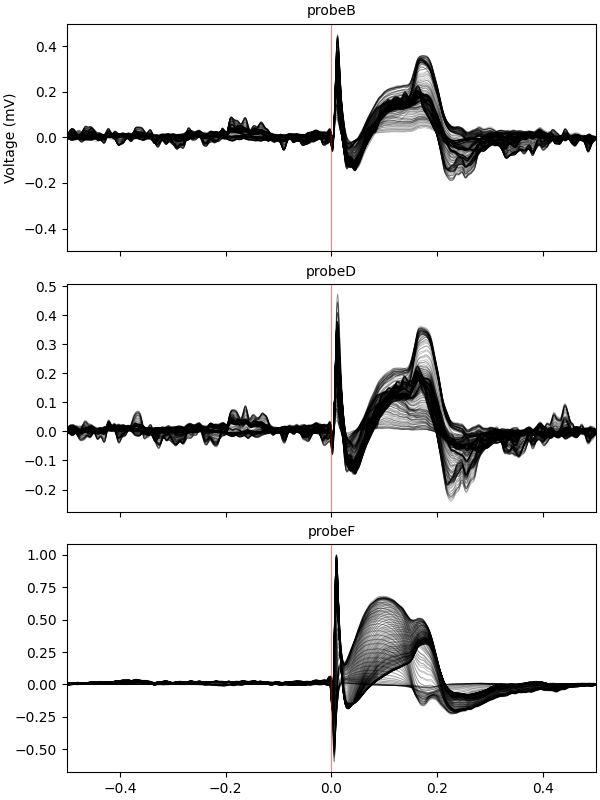

In [18]:
stim_type = 'biphasic' # 'fullscreen', 'auditory', 'biphasic'
stim_amp = '35' # current amplitude = [20, 50, 70, 100]
sweep = 0
pl_ctx = False

y_max = 0.5

fig, axs = plt.subplots(len(probe_list), 1, figsize=(6,8), sharex=True, constrained_layout=True)
for ax, probei in zip(axs, probe_list):
    timex = probe_LFP_traces[probei][stim_type][stim_amp][sweep][0]
    traces = np.mean(probe_LFP_traces[probei][stim_type][stim_amp][sweep][1], axis=2)/1000
    if pl_ctx:
        ax.plot(timex, traces[:,probe_info[probei]['ctx_mask']], color='k', linewidth=0.6, alpha=0.25)
    else:
        ax.plot(timex, traces, color='k', linewidth=0.6, alpha=0.25)
    ax.axvline(0, color='r', linewidth=0.8, alpha=0.5)
    ax.set_title(probei)
    
axs[0].set_xlim([timex[0], timex[-1]])
axs[0].set_ylim([-y_max, y_max])
axs[0].set_ylabel('Voltage (mV)')

### SAVE ###
fig_name = '{}_NPX-LFP_allprobes_{}_sweep{}_1200.png'.format(exp_tag, str(stim_amp), sweep)
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=True)

### Calculate PCI with LFP